## Exp-031 (ULMS BERT)

Exp-019からの変更点<br>
　-　dropoutなし<br>
　-　最終4層のConcat
- 各層に異なった学習率を適用

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!nvidia-smi

Mon Sep 13 12:24:28 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    24W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
!pip install transformers pycld2

     |████████████████████████████████| 2.8 MB 13.0 MB/s 
     |████████████████████████████████| 41.4 MB 1.2 MB/s 
     |████████████████████████████████| 3.3 MB 63.8 MB/s 
     |████████████████████████████████| 636 kB 56.2 MB/s 
     |████████████████████████████████| 895 kB 57.0 MB/s 
     |████████████████████████████████| 50 kB 7.8 MB/s 
  Created wheel for pycld2: filename=pycld2-0.41-cp37-cp37m-linux_x86_64.whl size=9834220 sha256=f1dcf9960d5b94103821e405882a8d65e1f808f9c94bf581229db02d17903f65
  Stored in directory: /root/.cache/pip/wheels/ed/e4/58/ed2e9f43c07d617cc81fe7aff0fc6e42b16c9cf6afe960b614
Successfully built pycld2
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [4]:
input_dir = "/content/drive/MyDrive/07_Competition/signate-471/data/"
output_dir = "/content/drive/MyDrive/07_Competition/signate-471/log/"
submission_dir = "/content/drive/MyDrive/07_Competition/signate-471/submission/"
model_dir = "/content/drive/MyDrive/07_Competition/signate-471/model_bin/"
pred_dir = "/content/drive/MyDrive/07_Competition/signate-471/pred/"

In [5]:
import os
import math
import random
import pandas as pd
import numpy as np
from glob import glob
import gc
gc.enable()

import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim as optim
from torch.optim.optimizer import Optimizer
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import Dataset, DataLoader, SequentialSampler, RandomSampler

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import fbeta_score

from transformers import BertConfig, RobertaConfig
from transformers import (get_cosine_schedule_with_warmup, get_cosine_with_hard_restarts_schedule_with_warmup)
from transformers import BertTokenizer, RobertaTokenizer
from transformers import BertModel, RobertaModel
from transformers import AutoConfig, BertConfig, RobertaConfig
from transformers import BertForSequenceClassification, RobertaForSequenceClassification
from torch import cuda
import time

from transformers import AdamW
from transformers import AutoTokenizer
from transformers import AutoModel, AutoModelForSequenceClassification
from transformers import MODEL_FOR_SEQUENCE_CLASSIFICATION_MAPPING
from transformers import get_linear_schedule_with_warmup

from IPython.display import clear_output
from tqdm import tqdm, trange

import re
import nltk
import pycld2 as cld2
from scipy.optimize import minimize, minimize_scalar
import regex
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [33]:
class CFG:
  exp = "exp30h"
  seed = 71
  fold = 5
  max_len = 280
  epochs = 1
  lr = 2e-5
  train_batch_size = 16
  valid_batch_size = 32
  model_name = "GanjinZero/UMLSBert_ENG"

CONFIG = CFG()

In [34]:
os.makedirs(model_dir+CONFIG.exp+"/", exist_ok=True)
os.makedirs(pred_dir+CONFIG.exp+"/", exist_ok=True)
os.makedirs(output_dir+CONFIG.exp+"/", exist_ok=True)

In [35]:
def set_random_seed(random_seed):
    random.seed(random_seed)
    np.random.seed(random_seed)
    os.environ["PYTHONHASHSEED"] = str(random_seed)

    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)

    torch.backends.cudnn.deterministic = True

set_random_seed(CONFIG.seed)

In [36]:
DEVICE = torch.device('cuda') if cuda.is_available() else 'cpu'

In [37]:
def init_logger(log_file=output_dir + CONFIG.exp+ f"/{CONFIG.exp}_train.log"):
    from logging import INFO, FileHandler, Formatter, StreamHandler, getLogger

    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = init_logger()

In [38]:
def get_train_data(train):
    # 交差検証 用の番号を振ります。
    Fold = StratifiedKFold(n_splits=CONFIG.fold, shuffle=True, random_state=CONFIG.seed)
    for n, (train_index, val_index) in enumerate(Fold.split(train, train["judgement"])):
        train.loc[val_index, "fold"] = int(n)
    train["fold"] = train["fold"].astype(np.uint8)

    return train

def get_test_data(test):
    return test

In [39]:
class SRWSDataset(Dataset):
  def __init__(self, df, inference_only=False):

    # Berttokenizer
    tokenizer = BertTokenizer.from_pretrained(CONFIG.model_name)

    self.df = df
    self.inference_only = inference_only # "train":False or "test":True
    self.text = self.df["title_abst"].tolist() # text

    if not self.inference_only:
      # ここvalueだけ
      self.target = df["judgement"].values
      
    self.encoded = tokenizer.batch_encode_plus(
        self.text,
        padding = "max_length",
        max_length = CONFIG.max_len,
        truncation = True,
        return_attention_mask=True
    )

  def __len__(self):
    return len(self.df)

  def __getitem__(self, index):
    input_ids = torch.tensor(self.encoded["input_ids"][index])
    attention_mask = torch.tensor(self.encoded["attention_mask"][index])

    # returnをsetかdictで返すかは自由
    if self.inference_only:
      return (input_ids, attention_mask)

    else:
      # ここで、tensor に変更している
      target = torch.tensor(self.target[index]).float()
      return (input_ids, attention_mask, target)


In [40]:
class SRWSBertModel(nn.Module):
  def __init__(self):
    super().__init__()

    self.config = BertConfig.from_pretrained(CFG.model_name)
    self.config.update({"output_hidden_states": True})
    self.config.hidden_dropout_prob = 0
    self.config.attention_probs_dropout_prob = 0
    self.bert = BertModel.from_pretrained(CONFIG.model_name, config=self.config)
    self.regressor = nn.Linear(self.config.hidden_size*4, 1)
    self.sigmoid = nn.Sigmoid()

  def forward(self, input_ids, attention_mask):
    output = self.bert(input_ids=input_ids, attention_mask=attention_mask) 
    sequence_output = torch.cat([output["hidden_states"][-1*i][:,0] for i in range(1, 4+1)], dim=1)
    bert_output = self.regressor(sequence_output)
    bert_output = self.sigmoid(bert_output).squeeze()

    return bert_output

In [41]:
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return "%dm %ds" % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return "%s (remain %s)" % (asMinutes(s), asMinutes(rs))

In [71]:
# 学習
def train_fn(model, train_loader, optimizer, epoch, loss_function, scheduler=None):
  start = end = time.time()
  losses = AverageMeter()
  model.train()

  for batch_num, (input_ids, attention_mask, target) in enumerate(train_loader):
    optimizer.zero_grad()

    input_ids = input_ids.to(DEVICE)
    attention_mask = attention_mask.to(DEVICE)
    target = target.to(DEVICE)
    batch_size = target.size(0)

    pred = model(input_ids, attention_mask)

    # Loss算出
    #print(pred)
    loss = loss_function(pred, target)
    losses.update(loss.item(), batch_size)
    loss.backward()

    optimizer.step()

    if scheduler:
      scheduler.step()

    if batch_num % 100 == 0 or batch_num == (len(train_loader) -1):
      print(
            f"Epoch: [{epoch + 1}][{batch_num}/{len(train_loader)}] "
            f"Elapsed {timeSince(start, float(batch_num + 1) / len(train_loader)):s} "
            f"Loss: {losses.avg:.4f} "
            )
      
  return losses.avg

def valid_fn(valid_loader, model, loss_function):
  start = end = time.time()
  losses = AverageMeter()

  model.eval()
  preds = []

  for batch_num, (input_ids, attention_mask, target) in enumerate(valid_loader):
    input_ids = input_ids.to(DEVICE)
    attention_mask = attention_mask.to(DEVICE)
    target = target.to(DEVICE)
    batch_size = target.size(0)

    # compare loss
    with torch.no_grad():
      pred = model(input_ids, attention_mask)

    loss = loss_function(pred, target)
    losses.update(loss.item(), batch_size)

    # スコア追加
    preds.append(pred.to("cpu").numpy())

    if batch_num % 100 == 0 or batch_num == (len(valid_loader) - 1):
      print(
          f"EVAL: [{batch_num}/{len(valid_loader)}]"
          f"Elapsed {timeSince(start, float(batch_num+1) / len(valid_loader)):s}"
          f"Loss: {losses.avg:.4f}"
      )
  predictions = np.concatenate(preds)

  return losses.avg, predictions

# 予測
def inference():
    predictions = []

    test_dataset = SRWSDataset(test,  inference_only=True)
    test_loader = DataLoader(
        test_dataset, 
        batch_size=CONFIG.valid_batch_size, 
        shuffle=False, 
        num_workers=4, 
        pin_memory=True
    )

    for fold in range(CONFIG.fold):
        LOGGER.info(f"========== model: {CONFIG.model_name} fold: {fold} inference ==========")
        model = SRWSBertModel()
        model.to(DEVICE)
        model.load_state_dict(torch.load(model_dir +CONFIG.exp + "/"+ f"{CONFIG.model_name.split('/')[1]}_fold{fold}_best.pth")["model"])
        model.eval()
        preds = []
        for i, (input_ids, attention_mask) in tqdm(enumerate(test_loader), total=len(test_loader)):
            input_ids = input_ids.to(DEVICE)
            attention_mask = attention_mask.to(DEVICE)
            with torch.no_grad():
                y_preds = model(input_ids, attention_mask)
            preds.append(y_preds.to("cpu").numpy())
        preds = np.concatenate(preds)
        preds = preds**0.8
        predictions.append(preds)
    predictions = np.mean(predictions, axis=0)

    return predictions

In [65]:
# 最適化（使ってない）
# https://signate.jp/competitions/471/discussions/tf-roberta-base-baseline-cv08949-lb08734

def opt_fbeta_threshold(y_true, y_pred):
  """fbeta score計算時のthresholdを最適化"""
  def opt_(x):
    return -fbeta_score(y_true, y_pred >= x, beta=7)
  result = minimize(opt_, x0=np.array([0.02]), method='Powell')
  best_threshold = result['x'].item()
  return best_threshold

In [66]:
def get_optimizer_grouped_parameters(model):
    model_type = 'bert'
    no_decay = ["bias", "LayerNorm.weight"]
    optimizer_grouped_parameters = [
        {
            "params": [p for n, p in model.named_parameters()
                       if 'lstm' in n
                       or 'cnn' in n
                       or 'regressor' in n],
            "weight_decay": 0.0,
            "lr": 1e-3,
        },
    ]
    num_layers = model.config.num_hidden_layers
    layers = [getattr(model, model_type).embeddings] + list(getattr(model, model_type).encoder.layer)
    layers.reverse()
    lr = CONFIG.lr
    for layer in layers:
        lr *= 0.95
        optimizer_grouped_parameters += [
            {
                "params": [p for n, p in layer.named_parameters() if not any(nd in n for nd in no_decay)],
                "weight_decay": 0.1,
                "lr": lr,
            },
            {
                "params": [p for n, p in layer.named_parameters() if any(nd in n for nd in no_decay)],
                "weight_decay": 0.0,
                "lr": lr,
            },
        ]
    return optimizer_grouped_parameters

In [72]:
# LOOP
def train_loop(train, fold):
  LOGGER.info(f"========== fold: {fold} training ==========")

  # ====================================================
  # Data Loader
  # ====================================================
  trn_idx = train[train["fold"] != fold].index
  val_idx = train[train["fold"] == fold].index

  train_folds = train.loc[trn_idx].reset_index(drop=True)
  valid_folds = train.loc[val_idx].reset_index(drop=True)

  train_dataset = SRWSDataset(train_folds)
  valid_dataset = SRWSDataset(valid_folds)

  train_loader = DataLoader(
        train_dataset,
        batch_size=CONFIG.train_batch_size,
        shuffle=True,
        num_workers=4,
        pin_memory=True, # https://qiita.com/sugulu_Ogawa_ISID/items/62f5f7adee083d96a587
        drop_last=True,
  )
  valid_loader = DataLoader(
        valid_dataset,
        batch_size=CONFIG.valid_batch_size,
        shuffle=False,
        num_workers=4,
        pin_memory=True,
        drop_last=False,
  )

  # ====================================================
  # Model
  # ====================================================
  model = SRWSBertModel()
  model.to(DEVICE)

  optimizer_parameters = get_optimizer_grouped_parameters(model)

  #optimizer = AdamW(model.parameters(), lr=CONFIG.lr)
  optimizer = AdamW(optimizer_parameters, lr=CONFIG.lr, weight_decay=0.1)

  # Loss_function
  loss_function = nn.BCELoss()

  # ====================================================
  # LOOP
  # ====================================================

  best_score = -1
  best_loss = np.inf
  best_borders=[]

  # 学習
  for epoch in range(CONFIG.epochs):
    start_time = time.time()

    # train
    avg_loss = train_fn(model, train_loader, optimizer, epoch, loss_function)

    # valid
    avg_val_loss, preds = valid_fn(valid_loader, model,loss_function)
    valid_labels = valid_folds["judgement"].values
    preds = preds**0.8

    # border最適化
    border_m = opt_fbeta_threshold(valid_labels, preds)
    best_borders.append(border_m)

    # score
    score = fbeta_score(valid_labels, np.where(preds < border_m, 0, 1), beta=7.0)

    elapsed = time.time() - start_time
    LOGGER.info(
            f"Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s"
    )
    LOGGER.info(f"Epoch {epoch+1} - Score: {score}")

    if score > best_score:
      best_score = score
      LOGGER.info(f"Epoch {epoch+1} - Save Best Score: {best_score:.4f} ")
      torch.save(
                {"model": model.state_dict(), "preds": preds}, model_dir +CONFIG.exp + "/"+ f"{CONFIG.model_name.split('/')[1]}_fold{fold}_best.pth"
      ) # scibertでの変更
  check_point = torch.load(model_dir +CONFIG.exp + "/"+ f"{CONFIG.model_name.split('/')[1]}_fold{fold}_best.pth")

  valid_folds["preds"] = check_point["preds"]

  return valid_folds,best_borders

In [68]:
def get_result(result_df):
    preds = result_df["preds"].values
    labels = result_df["judgement"].values
    best_threshold = opt_fbeta_threshold(labels, preds)
    print("Best_Threshold：" + str(best_threshold))
    # 上実行すると、ValueError: Classification metrics can't handle a mix of continuous and binary targets
    score = fbeta_score(labels, np.where(preds < best_threshold, 0, 1), beta=7.0)
    print("Score：" + str(score))
    LOGGER.info(f"Score: {score:<.5f}")

# inference用に、best_thresholdを出力するようにする関数
def get_result_for_cv(result_df,best_border):
    preds = result_df["preds"].values
    labels = result_df["judgement"].values
    #best_threshold = opt_fbeta_threshold(labels, preds)
    print("Best_Threshold：" + str(best_border))
    # 上実行すると、ValueError: Classification metrics can't handle a mix of continuous and binary targets
    score = fbeta_score(labels, np.where(preds < best_border, 0, 1), beta=7.0)
    LOGGER.info(f"Score: {score:<.5f}")

    return score

def mean_best_border(*best_borders):
    best_border = np.mean(best_borders)
    print("Best_Threshold：" + str(best_border))
    LOGGER.info(f"Best_Border: {best_border:<.8f}")

    return best_border

In [69]:
def clean_stopword(text):
  stopwords = nltk.corpus.stopwords.words('english')
  list_x = text.split()
  res = []
  for w in list_x:
    if w not in stopwords:
      res.append(w)
  return ' '.join(res)

def clean_puncts(x):
  # 化学式とかがあるから '-'は削除しないほうがいいか？

  puncts = [',', '.', '"', ':', ')', '(', '-', '!', '?', '|', ';', "'", '$', '&', '/', '[', ']', '>', '%', '=', '#', '*', '+', '\\', '•',  '~', '@', '£',
            '·', '_', '{', '}', '©', '^', '®', '`',  '<', '→', '°', '€', '™', '›',  '♥', '←', '×', '§', '″', '′', 'Â', '█', '½', 'à', '…',
            '“', '★', '”', '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶', '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─',
            '▒', '：', '¼', '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲', 'è', '¸', '¾', 'Ã', '⋅', '‘', '∞', '«',
            '∙', '）', '↓', '、', '│', '（', '»', '，', '♪', '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø', '¹', '≤', '‡', '√', '（', '）', '～',
            '➡', '％', '⇒', '▶', '「', '➄', '➆',  '➊', '➋', '➌', '➍', '⓪', '①', '②', '③', '④', '⑤', '⑰', '❶', '❷', '❸', '❹', '❺', '❻', '❼', '❽',  
            '＝', '※', '㈱', '､', '△', '℮', 'ⅼ', '‐', '｣', '┝', '↳', '◉', '／', '＋', '○',
            '【', '】', '✅', '☑', '➤', 'ﾞ', '↳', '〶', '☛', '｢', '⁺', '『', '≫',
            'Â©', '<sub>','Aﾎｲ', 'ﾎｲ', "ﾃｩ"
          ] 
  # 文字化け対応はここで対応するしかない？
  
  for punct in puncts:
    x = x.replace(punct, '')
  return x

def _pre_preprocess(x):
  return str(x).lower() 

def rm_num(x, use_num=True):
  numbers = ["0","1","2","3","4","5","6","7","8","9","０","１","２","３","４","５","６","７","８","９"]
  x = re.sub('[0-9]{5,}', '', x)
  x = re.sub('[0-9]{4}', '', x)
  x = re.sub('[0-9]{3}', '', x)
  x = re.sub('[0-9]{2}', '', x)    
  for i in numbers:
    x = x.replace(str(i), '')        
  return x

def convert_mojibake(text):
  text = text.encode("shift-jis").decode("utf-8", errors="ignore")
  return text

def remove_double(text):
  text = text.replace("  ", " ")
  return text

def preprocess_text(text):
  #text = _pre_preprocess(text)
  #text = clean_stopword(text)
  text = clean_puncts(text)
  text = rm_num(text)
  text = remove_double(text)

  return text

def split_copyright(text):
  if "Copyright" in text:
    text = text.split('Copyright')[0]
    return text
  else:
    return text


In [48]:
pd.set_option("display.max_colwidth", 50)
train = pd.read_csv(input_dir + "train.csv")
test = pd.read_csv(input_dir + "test.csv")
sub = pd.read_csv(input_dir + "sample_submit.csv", header=None)
sub.columns = ["id", "judgement"]

In [49]:
# ラベル変更
# https://signate.jp/competitions/471/discussions/20210816152356-59

train.loc[train["id"]==2488, "judgement"] = 0
train.loc[train["id"]==7708, "judgement"] = 0

In [50]:
train = get_train_data(train)
train.head()

,id,title,abstract,judgement,fold
0,0,One-year age changes in MRI brain volumes in o...,Longitudinal studies indicate that declines in...,0,4
1,1,Supportive CSF biomarker evidence to enhance t...,The present study was undertaken to validate t...,0,3
2,2,Occurrence of basal ganglia germ cell tumors w...,Objective: To report a case series in which ba...,0,2
3,3,New developments in diagnosis and therapy of C...,The etiology and pathogenesis of idiopathic ch...,0,0
4,4,Prolonged shedding of SARS-CoV-2 in an elderly...,NaN,0,1


In [51]:
train["title_abst"] = train["title"] + train["abstract"]
train["title_abst"].fillna(train["title"], inplace=True)

test["title_abst"] = test["title"] + test["abstract"]
test["title_abst"].fillna(test["title"], inplace=True)

train.head()

,id,title,abstract,judgement,fold,title_abst
0,0,One-year age changes in MRI brain volumes in o...,Longitudinal studies indicate that declines in...,0,4,One-year age changes in MRI brain volumes in o...
1,1,Supportive CSF biomarker evidence to enhance t...,The present study was undertaken to validate t...,0,3,Supportive CSF biomarker evidence to enhance t...
2,2,Occurrence of basal ganglia germ cell tumors w...,Objective: To report a case series in which ba...,0,2,Occurrence of basal ganglia germ cell tumors w...
3,3,New developments in diagnosis and therapy of C...,The etiology and pathogenesis of idiopathic ch...,0,0,New developments in diagnosis and therapy of C...
4,4,Prolonged shedding of SARS-CoV-2 in an elderly...,NaN,0,1,Prolonged shedding of SARS-CoV-2 in an elderly...


In [52]:
# preprocess
train["title_abst"] = train["title_abst"].apply(lambda x: preprocess_text(x))
test["title_abst"] = test["title_abst"].apply(lambda x: preprocess_text(x))

# titleの単語数が3以下のものは除外してみる
train["title_word_len"] = train["title"].str.split(" ").str.len()
train = train[train["title_word_len"]>3]

# titleが他言語の場合は除外
train["title_lang"] = train["title"].fillna("").map(lambda x: cld2.detect(x)[2][0][1])
train = train[(train["title_lang"]=="en")|(train["title_lang"]=="un")]

# copyright以降は削除したい
train["title_abst"] = train["title_abst"].apply(lambda x: split_copyright(x))
test["title_abst"] = test["title_abst"].apply(lambda x: split_copyright(x))

In [73]:
# Training
#border = len(train[train["judgement"] == 1]) / len(train["judgement"]) # 0.023245467689912133
#border = border * 0.6

mean_border_folds = []
 
oof_df = pd.DataFrame()
for fold in range(CONFIG.fold):
  _oof_df,best_borders = train_loop(train, fold)
  oof_df = pd.concat([oof_df, _oof_df])
  LOGGER.info(f"========== fold: {fold} result ==========")
  best_border_fold = mean_best_border(best_borders)
  mean_border_folds.append(best_border_fold)
        
# CV result
LOGGER.info(f"========== CV ==========")
best_border = mean_best_border(mean_border_folds)
get_result_for_cv(oof_df,best_border)
    
# Save OOF result
oof_df.to_csv(pred_dir +CONFIG.exp + "/oof_df.csv", index=False)

========== fold: 0 training ==========


Epoch: [1][0/1345] Elapsed 0m 0s (remain 9m 47s) Loss: 1.7668 
Epoch: [1][100/1345] Elapsed 0m 25s (remain 5m 11s) Loss: 0.1176 
Epoch: [1][200/1345] Elapsed 0m 50s (remain 4m 45s) Loss: 0.0944 
Epoch: [1][300/1345] Elapsed 1m 15s (remain 4m 20s) Loss: 0.0790 
Epoch: [1][400/1345] Elapsed 1m 40s (remain 3m 55s) Loss: 0.0732 
Epoch: [1][500/1345] Elapsed 2m 5s (remain 3m 30s) Loss: 0.0690 
Epoch: [1][600/1345] Elapsed 2m 30s (remain 3m 5s) Loss: 0.0660 
Epoch: [1][700/1345] Elapsed 2m 55s (remain 2m 40s) Loss: 0.0643 
Epoch: [1][800/1345] Elapsed 3m 20s (remain 2m 16s) Loss: 0.0626 
Epoch: [1][900/1345] Elapsed 3m 45s (remain 1m 51s) Loss: 0.0607 
Epoch: [1][1000/1345] Elapsed 4m 10s (remain 1m 26s) Loss: 0.0595 
Epoch: [1][1100/1345] Elapsed 4m 35s (remain 1m 1s) Loss: 0.0587 
Epoch: [1][1200/1345] Elapsed 5m 0s (remain 0m 36s) Loss: 0.0579 
Epoch: [1][1300/1345] Elapsed 5m 25s (remain 0m 11s) Loss: 0.0566 
Epoch: [1][1344/1345] Elapsed 5m 36s (remain 0m 0s) Loss: 0.0564 
EVAL: [0/169]

Epoch 1 - avg_train_loss: 0.0564  avg_val_loss: 0.0420  time: 364s
Epoch 1 - Score: 0.8841321544904607
Epoch 1 - Save Best Score: 0.8841 
========== fold: 0 result ==========
Best_Border: 0.07277509
========== fold: 1 training ==========


Best_Threshold：0.07277508640293444
Epoch: [1][0/1346] Elapsed 0m 0s (remain 10m 1s) Loss: 0.9541 
Epoch: [1][100/1346] Elapsed 0m 25s (remain 5m 12s) Loss: 0.1183 
Epoch: [1][200/1346] Elapsed 0m 50s (remain 4m 46s) Loss: 0.1014 
Epoch: [1][300/1346] Elapsed 1m 15s (remain 4m 21s) Loss: 0.1007 
Epoch: [1][400/1346] Elapsed 1m 40s (remain 3m 56s) Loss: 0.0871 
Epoch: [1][500/1346] Elapsed 2m 5s (remain 3m 31s) Loss: 0.0816 
Epoch: [1][600/1346] Elapsed 2m 30s (remain 3m 6s) Loss: 0.0775 
Epoch: [1][700/1346] Elapsed 2m 55s (remain 2m 41s) Loss: 0.0744 
Epoch: [1][800/1346] Elapsed 3m 20s (remain 2m 16s) Loss: 0.0723 
Epoch: [1][900/1346] Elapsed 3m 45s (remain 1m 51s) Loss: 0.0685 
Epoch: [1][1000/1346] Elapsed 4m 10s (remain 1m 26s) Loss: 0.0672 
Epoch: [1][1100/1346] Elapsed 4m 35s (remain 1m 1s) Loss: 0.0662 
Epoch: [1][1200/1346] Elapsed 5m 0s (remain 0m 36s) Loss: 0.0641 
Epoch: [1][1300/1346] Elapsed 5m 25s (remain 0m 11s) Loss: 0.0622 
Epoch: [1][1345/1346] Elapsed 5m 36s (remain

Epoch 1 - avg_train_loss: 0.0619  avg_val_loss: 0.0485  time: 364s
Epoch 1 - Score: 0.8807169344870208
Epoch 1 - Save Best Score: 0.8807 


EVAL: [167/168]Elapsed 0m 27s (remain 0m 0s)Loss: 0.0485


========== fold: 1 result ==========
Best_Border: 0.01995671
========== fold: 2 training ==========


Best_Threshold：0.019956714652950257
Epoch: [1][0/1345] Elapsed 0m 0s (remain 10m 0s) Loss: 1.1943 
Epoch: [1][100/1345] Elapsed 0m 25s (remain 5m 12s) Loss: 0.0884 
Epoch: [1][200/1345] Elapsed 0m 50s (remain 4m 46s) Loss: 0.0827 
Epoch: [1][300/1345] Elapsed 1m 15s (remain 4m 21s) Loss: 0.0766 
Epoch: [1][400/1345] Elapsed 1m 40s (remain 3m 56s) Loss: 0.0716 
Epoch: [1][500/1345] Elapsed 2m 5s (remain 3m 31s) Loss: 0.0687 
Epoch: [1][600/1345] Elapsed 2m 30s (remain 3m 6s) Loss: 0.0694 
Epoch: [1][700/1345] Elapsed 2m 55s (remain 2m 41s) Loss: 0.0656 
Epoch: [1][800/1345] Elapsed 3m 20s (remain 2m 16s) Loss: 0.0631 
Epoch: [1][900/1345] Elapsed 3m 45s (remain 1m 51s) Loss: 0.0621 
Epoch: [1][1000/1345] Elapsed 4m 10s (remain 1m 26s) Loss: 0.0610 
Epoch: [1][1100/1345] Elapsed 4m 35s (remain 1m 1s) Loss: 0.0592 
Epoch: [1][1200/1345] Elapsed 5m 0s (remain 0m 36s) Loss: 0.0575 
Epoch: [1][1300/1345] Elapsed 5m 25s (remain 0m 11s) Loss: 0.0554 
Epoch: [1][1344/1345] Elapsed 5m 36s (remai

Epoch 1 - avg_train_loss: 0.0559  avg_val_loss: 0.0466  time: 364s
Epoch 1 - Score: 0.9321006365565323
Epoch 1 - Save Best Score: 0.9321 


EVAL: [168/169]Elapsed 0m 27s (remain 0m 0s)Loss: 0.0466


========== fold: 2 result ==========
Best_Border: 0.12630550
========== fold: 3 training ==========


Best_Threshold：0.12630549750042808
Epoch: [1][0/1346] Elapsed 0m 0s (remain 10m 4s) Loss: 0.6296 
Epoch: [1][100/1346] Elapsed 0m 25s (remain 5m 12s) Loss: 0.1253 
Epoch: [1][200/1346] Elapsed 0m 50s (remain 4m 46s) Loss: 0.0930 
Epoch: [1][300/1346] Elapsed 1m 15s (remain 4m 21s) Loss: 0.0793 
Epoch: [1][400/1346] Elapsed 1m 40s (remain 3m 56s) Loss: 0.0756 
Epoch: [1][500/1346] Elapsed 2m 5s (remain 3m 31s) Loss: 0.0745 
Epoch: [1][600/1346] Elapsed 2m 30s (remain 3m 6s) Loss: 0.0724 
Epoch: [1][700/1346] Elapsed 2m 55s (remain 2m 41s) Loss: 0.0693 
Epoch: [1][800/1346] Elapsed 3m 20s (remain 2m 16s) Loss: 0.0675 
Epoch: [1][900/1346] Elapsed 3m 45s (remain 1m 51s) Loss: 0.0675 
Epoch: [1][1000/1346] Elapsed 4m 10s (remain 1m 26s) Loss: 0.0642 
Epoch: [1][1100/1346] Elapsed 4m 35s (remain 1m 1s) Loss: 0.0621 
Epoch: [1][1200/1346] Elapsed 5m 0s (remain 0m 36s) Loss: 0.0600 
Epoch: [1][1300/1346] Elapsed 5m 25s (remain 0m 11s) Loss: 0.0580 
Epoch: [1][1345/1346] Elapsed 5m 37s (remain

Epoch 1 - avg_train_loss: 0.0588  avg_val_loss: 0.0369  time: 364s
Epoch 1 - Score: 0.9108702198133093
Epoch 1 - Save Best Score: 0.9109 
========== fold: 3 result ==========
Best_Border: 0.06094613
========== fold: 4 training ==========


Best_Threshold：0.06094612760400824
Epoch: [1][0/1346] Elapsed 0m 0s (remain 9m 44s) Loss: 0.5413 
Epoch: [1][100/1346] Elapsed 0m 25s (remain 5m 12s) Loss: 0.0842 
Epoch: [1][200/1346] Elapsed 0m 50s (remain 4m 46s) Loss: 0.0776 
Epoch: [1][300/1346] Elapsed 1m 15s (remain 4m 21s) Loss: 0.0692 
Epoch: [1][400/1346] Elapsed 1m 40s (remain 3m 56s) Loss: 0.0663 
Epoch: [1][500/1346] Elapsed 2m 5s (remain 3m 31s) Loss: 0.0616 
Epoch: [1][600/1346] Elapsed 2m 30s (remain 3m 6s) Loss: 0.0635 
Epoch: [1][700/1346] Elapsed 2m 55s (remain 2m 41s) Loss: 0.0632 
Epoch: [1][800/1346] Elapsed 3m 20s (remain 2m 16s) Loss: 0.0614 
Epoch: [1][900/1346] Elapsed 3m 45s (remain 1m 51s) Loss: 0.0607 
Epoch: [1][1000/1346] Elapsed 4m 10s (remain 1m 26s) Loss: 0.0586 
Epoch: [1][1100/1346] Elapsed 4m 35s (remain 1m 1s) Loss: 0.0577 
Epoch: [1][1200/1346] Elapsed 5m 0s (remain 0m 36s) Loss: 0.0572 
Epoch: [1][1300/1346] Elapsed 5m 25s (remain 0m 11s) Loss: 0.0565 
Epoch: [1][1345/1346] Elapsed 5m 36s (remain

Epoch 1 - avg_train_loss: 0.0560  avg_val_loss: 0.0522  time: 364s
Epoch 1 - Score: 0.9010384850335982
Epoch 1 - Save Best Score: 0.9010 
========== fold: 4 result ==========
Best_Border: 0.03460183
========== CV ==========
Best_Border: 0.06291705
Score: 0.87222


Best_Threshold：0.034601829552407815
Best_Threshold：0.06291705114254577
Best_Threshold：0.06291705114254577


In [74]:
best_border

0.06291705114254577

In [75]:
predictions = inference()

# stacking用にpredictionを保存
pred_df = pd.DataFrame()
pred_df["id"] = test["id"]
pred_df["judgement"] = predictions
pred_df.to_csv(pred_dir +CONFIG.exp + "/pred_df.csv", index=False)

predictions = np.where(predictions < best_border, 0, 1)

# submission
sub["judgement"] = predictions
sub.to_csv(submission_dir +CONFIG.exp+ "_submission.csv", index=False, header=False)

========== model: GanjinZero/UMLSBert_ENG fold: 0 inference ==========
100%|██████████| 1277/1277 [03:25<00:00,  6.20it/s]
========== model: GanjinZero/UMLSBert_ENG fold: 1 inference ==========
100%|██████████| 1277/1277 [03:25<00:00,  6.21it/s]
========== model: GanjinZero/UMLSBert_ENG fold: 2 inference ==========
100%|██████████| 1277/1277 [03:25<00:00,  6.21it/s]
========== model: GanjinZero/UMLSBert_ENG fold: 3 inference ==========
100%|██████████| 1277/1277 [03:25<00:00,  6.21it/s]
========== model: GanjinZero/UMLSBert_ENG fold: 4 inference ==========
100%|██████████| 1277/1277 [03:25<00:00,  6.21it/s]


In [9]:
pred_df=pd.read_csv(pred_dir +CONFIG.exp + "/pred_df.csv")

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


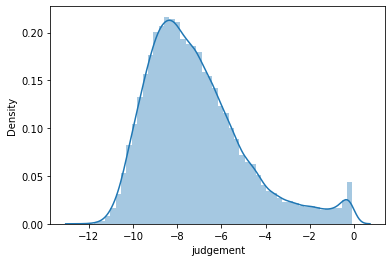

In [15]:
import seaborn as sns
sns.distplot(np.log(pred_df["judgement"]))

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


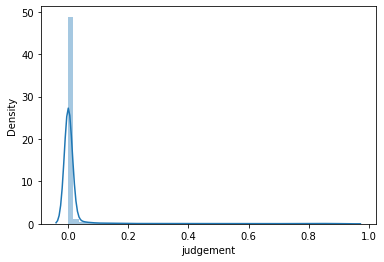

In [17]:
sns.distplot(pred_df["judgement"])

In [16]:
oof_df=pd.read_csv(pred_dir +CONFIG.exp + "/oof_df.csv")

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


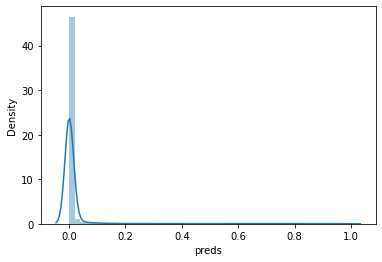

In [25]:
sns.distplot(oof_df["preds"])

In [23]:
oof_df

,id,title,abstract,judgement,fold,title_abst,title_word_len,title_lang,preds
0,3,New developments in diagnosis and therapy of C...,The etiology and pathogenesis of idiopathic ch...,0,0,New developments in diagnosis and therapy of C...,13,en,0.008044
1,8,Rehabilitation and Covid-19: the Cochrane Reha...,INTRODUCTION: This paper improves the methodol...,0,0,Rehabilitation and Covid the Cochrane Rehabili...,11,en,0.004878
2,25,"COVID-19, impact on myeloma patients",NaN,0,0,COVID impact on myeloma patients,5,en,0.000690
3,26,SARS-CoV-2 Positive Hospitalized Cancer Patien...,In the coronavirus disease (COVID-19) pandemic...,0,0,SARSCoV Positive Hospitalized Cancer Patients ...,15,en,0.000190
4,27,Value of echographic examination in the study ...,Beside conventional radiology and bone scintig...,0,0,Value of echographic examination in the study ...,9,en,0.009271
...,...,...,...,...,...,...,...,...,...
26916,27123,Utility of the combination of DAT SPECT and MI...,Purpose: 123I-2β-Carbomethoxy-3β-(4-iodophenyl...,1,4,Utility of the combination of DAT SPECT and MI...,20,en,0.890052
26917,27130,Tocilizumab use in COVID -19 associated pneumonia,BACKGROUND: We sought to evaluate the effect o...,0,4,Tocilizumab use in COVID associated pneumoniaB...,7,en,0.000052
26918,27138,Mortality of high-risk orthopaedic oncology pa...,BACKGROUND AND OBJECTIVES: Should the threshol...,0,4,Mortality of highrisk orthopaedic oncology pat...,14,en,0.000035
26919,27141,Technologic developments in radiotherapy and s...,We present a review of current technological p...,0,4,Technologic developments in radiotherapy and s...,7,en,0.000340


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


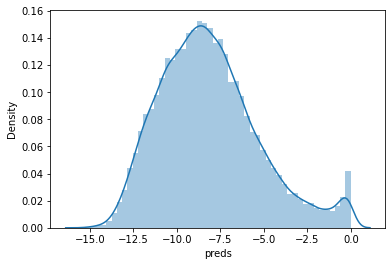

In [24]:
sns.distplot(np.log(oof_df["preds"]))

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


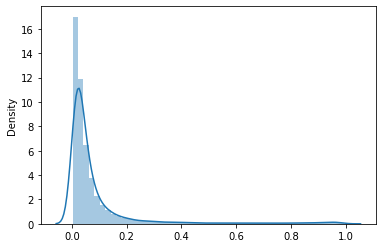

In [32]:
sns.distplot(oof_df["preds"].values ** 0.4)